In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('AAPL.csv')
df_copy = df.copy()

In [4]:
#MACD

def MACD(Df, a, b, c):

    df = Df.copy()
    df['MA_Fast'] = df['Adj Close'].ewm(span = a , min_periods = a).mean()
    df['MA_Slow'] = df['Adj Close'].ewm(span = b , min_periods = b).mean()
    df['MACD'] = df['MA_Fast'] - df['MA_Slow']
    df['Signal'] = df['MACD'].ewm(span = c, min_periods = c).mean()
    df.dropna(inplace = True)
    return df

In [5]:
#ATR

def ATR(Df, n):

    df = Df.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis = 1)
    return df2

<AxesSubplot:>

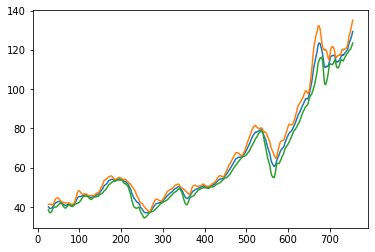

In [15]:
#Bollinger Band

def BollBnd(Df, n):

    df = Df.copy()
    df['MA'] = df['Adj Close'].rolling(n).mean()
    df['BB_up'] = df['Adj Close'].rolling(n).mean() + 2*df['MA'].rolling(n).std()
    df['BB_dn'] = df['Adj Close'].rolling(n).mean() - 2*df['MA'].rolling(n).std()
    df['BB_Width'] = df['BB_up'] - df['BB_dn']
    df.dropna(inplace = True)
    return df

BollBnd(df, 14)['MA'].plot()
BollBnd(df, 14)['BB_up'].plot()
BollBnd(df, 14)['BB_dn'].plot()

<AxesSubplot:>

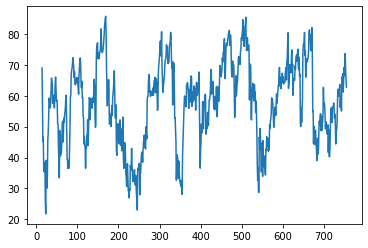

In [14]:
#RSI

def RSI(Df,n):

    df = Df.copy()
    df['delta'] = df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain'] = np.where(df['delta'] >= 0, df['delta'], 0)
    df['loss'] = np.where(df['delta'] < 0, abs(df['delta']), 0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()

    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    
    df['avg_gain'] = np.array(avg_gain)
    df['avg_loss'] = np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df

RSI(df,14)['RSI'].plot()
            

<AxesSubplot:>

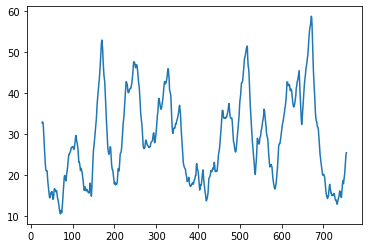

In [16]:
def ADX(DF,n):

    df2 = DF.copy()
    #the period parameter of ATR function does not matter because period does not influence TR calculation

    df2['TR'] = ATR(df2,n)['TR'] 
    df2['DMplus'] = np.where((df2['High'] - df2['High'].shift(1)) > (df2['Low'].shift(1) - df2['Low']), df2['High'] - df2['High'].shift(1), 0)
    df2['DMplus'] = np.where(df2['DMplus'] < 0, 0, df2['DMplus'])
    df2['DMminus'] = np.where((df2['Low'].shift(1) - df2['Low']) > (df2['High'] - df2['High'].shift(1)), df2['Low'].shift(1) - df2['Low'], 0)
    df2['DMminus'] = np.where(df2['DMminus'] < 0, 0, df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()

    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])

    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN'] = 100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN'] = 100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff'] = abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum'] = df2['DIplusN']+df2['DIminusN']
    df2['DX'] = 100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()

    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX'] = np.array(ADX)
    return df2['ADX']

ADX(df, 14).dropna().plot()